In [2]:
# Importing necessary libraries
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import copy
import shutil
import numpy as np
import ipywidgets as widgets
import wandb
from ultralytics import YOLO
load_dotenv()

True

## Login into Weights and Bias

In [3]:
WANDB_API_KEY = os.getenv("WANDB_API_KEY")
wandb.login(key=WANDB_API_KEY)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shaunliew20 (shaunliew20-organization). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/shaunliew/.netrc


True

## Preparing the images data

In [4]:
# Defining input images path, output path, masks path and labels path
path='dataset'
op_path='data'
rawimages_path=os.path.join(op_path, 'raw_images')
maskimages_path=os.path.join(op_path, 'mask_images')
labels_path=os.path.join(op_path, 'labels')
# os.makedirs(rawimages_path)
# os.makedirs(maskimages_path)
# os.makedirs(labels_path)

In [5]:
# Defining output train,val and test paths
imgtrainpath = os.path.join(op_path,'images','train')
imgvalpath=os.path.join(op_path,'images','validation')
imgtestpath=os.path.join(op_path,'images','test')

labeltrainpath=os.path.join(op_path,'labels','train')
labelvalpath=os.path.join(op_path,'labels','validation')
labeltestpath=os.path.join(op_path,'labels','test')

# os.makedirs(imgtrainpath)
# os.makedirs(imgvalpath)
# os.makedirs(imgtestpath)

# os.makedirs(labeltrainpath)
# os.makedirs(labelvalpath)
# os.makedirs(labeltestpath)

Now we transfer raw images and their corresponding color masks to their relevant output directories. 

Also we calculate the total number of sub-directories, total images, raw images and mask images

In [6]:
import os
import shutil
from collections import Counter

def process_images(root_path, rawimages_path, maskimages_path):
    stats = Counter()

    for directory in os.scandir(root_path):
        if not directory.is_dir():
            continue
        
        stats['directories'] += 1
        
        for sub_dir in os.scandir(directory.path):
            if not sub_dir.is_dir():
                continue
            
            stats['sub_directories'] += 1
            
            for image in os.scandir(sub_dir.path):
                if not image.is_file():
                    continue
                
                stats['total_images'] += 1
                newname = f"{sub_dir.name}_{image.name}"
                
                if 'mask' not in image.name:
                    process_image(image.path, rawimages_path, newname)
                    stats['raw_images'] += 1
                elif 'color_mask' in image.name:
                    process_image(image.path, maskimages_path, newname)
                    stats['masks'] += 1

    return stats

def process_image(src_path, dest_dir, new_name):
    try:
        dest_path = os.path.join(dest_dir, new_name)
        shutil.copy2(src_path, dest_path)
    except (IOError, OSError) as e:
        print(f"Error processing {src_path}: {e}")

In [9]:
root_path = path
rawimages_path = rawimages_path
maskimages_path = maskimages_path

stats = process_images(root_path, rawimages_path, maskimages_path)

print(f"Total directories: {stats['directories']}")
print(f"Total sub-directories: {stats['sub_directories']}")
print(f"Total images: {stats['total_images']}")
print(f"Total raw images: {stats['raw_images']}")
print(f"Total masks: {stats['masks']}")

Total directories: 17
Total sub-directories: 101
Total images: 32320
Total raw images: 8080
Total masks: 8080


We see here that we have equal number of raw images and masks. Let's verify if all the raw images and masks have been copied

In [7]:
# checking if all raw images and masks have been copied successfully
len(os.listdir(rawimages_path)), len(os.listdir(maskimages_path))

(8080, 8080)

In [8]:
# Checking first five raw images
os.listdir(rawimages_path)[:5]

['video17_01563_frame_1632_endo.png',
 'video20_03340_frame_3419_endo.png',
 'video01_14939_frame_14972_endo.png',
 'video52_02746_frame_2772_endo.png',
 'video37_01008_frame_1035_endo.png']

In [9]:
# Checking first five masks
os.listdir(maskimages_path)[:5]

['video28_00240_frame_288_endo_color_mask.png',
 'video01_28660_frame_28709_endo_color_mask.png',
 'video01_14859_frame_14924_endo_color_mask.png',
 'video25_00162_frame_170_endo_color_mask.png',
 'video28_00000_frame_16_endo_color_mask.png']

We see that the raw images and masks are not sorted in order. So we need to arrange them in order to visualize them as image-mask pairs

In [10]:
# Sorting raw images and masks
rawimages_list=sorted(os.listdir(rawimages_path))
maskimages_list=sorted(os.listdir(maskimages_path))

In [11]:
# Checking first five sorted raw images
rawimages_list[:5]

['video01_00080_frame_100_endo.png',
 'video01_00080_frame_101_endo.png',
 'video01_00080_frame_102_endo.png',
 'video01_00080_frame_103_endo.png',
 'video01_00080_frame_104_endo.png']

In [12]:
# Checking first five sorted masks
maskimages_list[:5]

['video01_00080_frame_100_endo_color_mask.png',
 'video01_00080_frame_101_endo_color_mask.png',
 'video01_00080_frame_102_endo_color_mask.png',
 'video01_00080_frame_103_endo_color_mask.png',
 'video01_00080_frame_104_endo_color_mask.png']

raw images and masks are now sorted.

## Visualising images and masks

define the color-class mapping corresponding to the class labels and the raw images given in the problem description.

In [13]:
from typing import Dict, Tuple, NamedTuple

class ColorClass(NamedTuple):
    color: Tuple[int, int, int]
    name: str

class SegmentationClasses:
    def __init__(self):
        # the colour scheme is given based on the documentation
        self.class_info: Dict[int, ColorClass] = {
            0: ColorClass((127, 127, 127), 'Black Background'),
            1: ColorClass((210, 140, 140), 'Abdominal Wall'),
            2: ColorClass((255, 114, 114), 'Liver'),
            3: ColorClass((231, 70, 156), 'Gastrointestinal Tract'),
            4: ColorClass((186, 183, 75), 'Fat'),
            5: ColorClass((170, 255, 0), 'Grasper'),
            6: ColorClass((255, 85, 0), 'Connective Tissue'),
            7: ColorClass((255, 0, 0), 'Blood'),
            8: ColorClass((255, 255, 0), 'Cystic Duct'),
            9: ColorClass((169, 255, 184), 'L-hook Electrocautery'),
            10: ColorClass((255, 160, 165), 'Gallbladder'),
            11: ColorClass((0, 50, 128), 'Hepatic Vein'),
            12: ColorClass((111, 74, 0), 'Liver Ligament')
        }
        
        self.color_to_class: Dict[Tuple[int, int, int], int] = {
            info.color: class_index for class_index, info in self.class_info.items()
        }
        
        self.name_to_class: Dict[str, int] = {
            info.name: class_index for class_index, info in self.class_info.items()
        }
    
    def get_class_from_color(self, color: Tuple[int, int, int]) -> int:
        return self.color_to_class.get(color, -1)  # Returns -1 if color not found
    
    def get_color_from_class(self, class_index: int) -> Tuple[int, int, int]:
        return self.class_info[class_index].color if class_index in self.class_info else (0, 0, 0)
    
    def get_name_from_class(self, class_index: int) -> str:
        return self.class_info[class_index].name if class_index in self.class_info else "Unknown"
    
    def get_class_from_name(self, name: str) -> int:
        return self.name_to_class.get(name, -1)  # Returns -1 if name not found
    
    def get_color_name(self, class_index: int) -> str:
        if class_index in self.class_info:
            color = self.class_info[class_index].color
            return f"RGB{color}"
        return "Unknown"


In [14]:
# Usage
segmentation_classes = SegmentationClasses()

# Examples
print(segmentation_classes.get_class_from_color((255, 0, 0)))  # Should print 7 (Blood)
print(segmentation_classes.get_color_from_class(2))  # Should print (255, 114, 114) (Liver)
print(segmentation_classes.get_name_from_class(5))  # Should print "Grasper"
print(segmentation_classes.get_class_from_name("Liver"))  # Should print 2
print(segmentation_classes.get_color_name(3))  # Should print "RGB(231, 70, 156)" (Gastrointestinal Tract)

7
(255, 114, 114)
Grasper
2
RGB(231, 70, 156)


In [15]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from typing import Tuple, List

def load_image(path: str) -> np.ndarray:
    """Load and convert an image to RGB."""
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def get_corresponding_mask_name(image_name: str) -> str:
    """Generate the corresponding mask name for a given image name."""
    return image_name.replace('_endo.png', '_endo_color_mask.png')

def plot_image_and_mask(rawimages_path: str, maskimages_path: str, figsize: Tuple[int, int] = (20, 10)) -> None:
    """
    Plot a random pair of raw image and its corresponding mask.
    
    Args:
    rawimages_path (str): Path to the directory containing raw images.
    maskimages_path (str): Path to the directory containing mask images.
    figsize (Tuple[int, int]): Figure size for the plot. Default is (20, 10).
    """
    rawimages_list = [f for f in os.listdir(rawimages_path) if f.endswith('_endo.png')]
    
    if not rawimages_list:
        print("No images found in the raw images directory.")
        return
    
    img_name = random.choice(rawimages_list)
    mask_name = get_corresponding_mask_name(img_name)
    
    img_path = os.path.join(rawimages_path, img_name)
    mask_path = os.path.join(maskimages_path, mask_name)
    
    if not os.path.exists(mask_path):
        print(f"Corresponding mask not found for {img_name}")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle("Raw Image vs Mask", fontsize=16)
    
    for ax, path, title in zip(axes, [img_path, mask_path], [img_name, mask_name]):
        image = load_image(path)
        ax.imshow(image)
        ax.set_title(title, fontsize=14)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_multiple_pairs(rawimages_path: str, maskimages_path: str, num_pairs: int = 3, figsize: Tuple[int, int] = (20, 20)) -> None:
    """
    Plot multiple random pairs of raw images and their corresponding masks.
    
    Args:
    rawimages_path (str): Path to the directory containing raw images.
    maskimages_path (str): Path to the directory containing mask images.
    num_pairs (int): Number of image-mask pairs to plot. Default is 3.
    figsize (Tuple[int, int]): Figure size for the plot. Default is (20, 20).
    """
    rawimages_list = [f for f in os.listdir(rawimages_path) if f.endswith('_endo.png')]
    
    if not rawimages_list:
        print("No images found in the raw images directory.")
        return
    
    fig, axes = plt.subplots(num_pairs, 2, figsize=figsize)
    fig.suptitle(f"{num_pairs} Random Image-Mask Pairs", fontsize=16)
    
    for row in axes:
        img_name = random.choice(rawimages_list)
        mask_name = get_corresponding_mask_name(img_name)
        
        img_path = os.path.join(rawimages_path, img_name)
        mask_path = os.path.join(maskimages_path, mask_name)
        
        if not os.path.exists(mask_path):
            print(f"Corresponding mask not found for {img_name}")
            continue
        
        for ax, path in zip(row, [img_path, mask_path]):
            image = load_image(path)
            ax.imshow(image)
            ax.set_title(os.path.basename(path), fontsize=10)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()


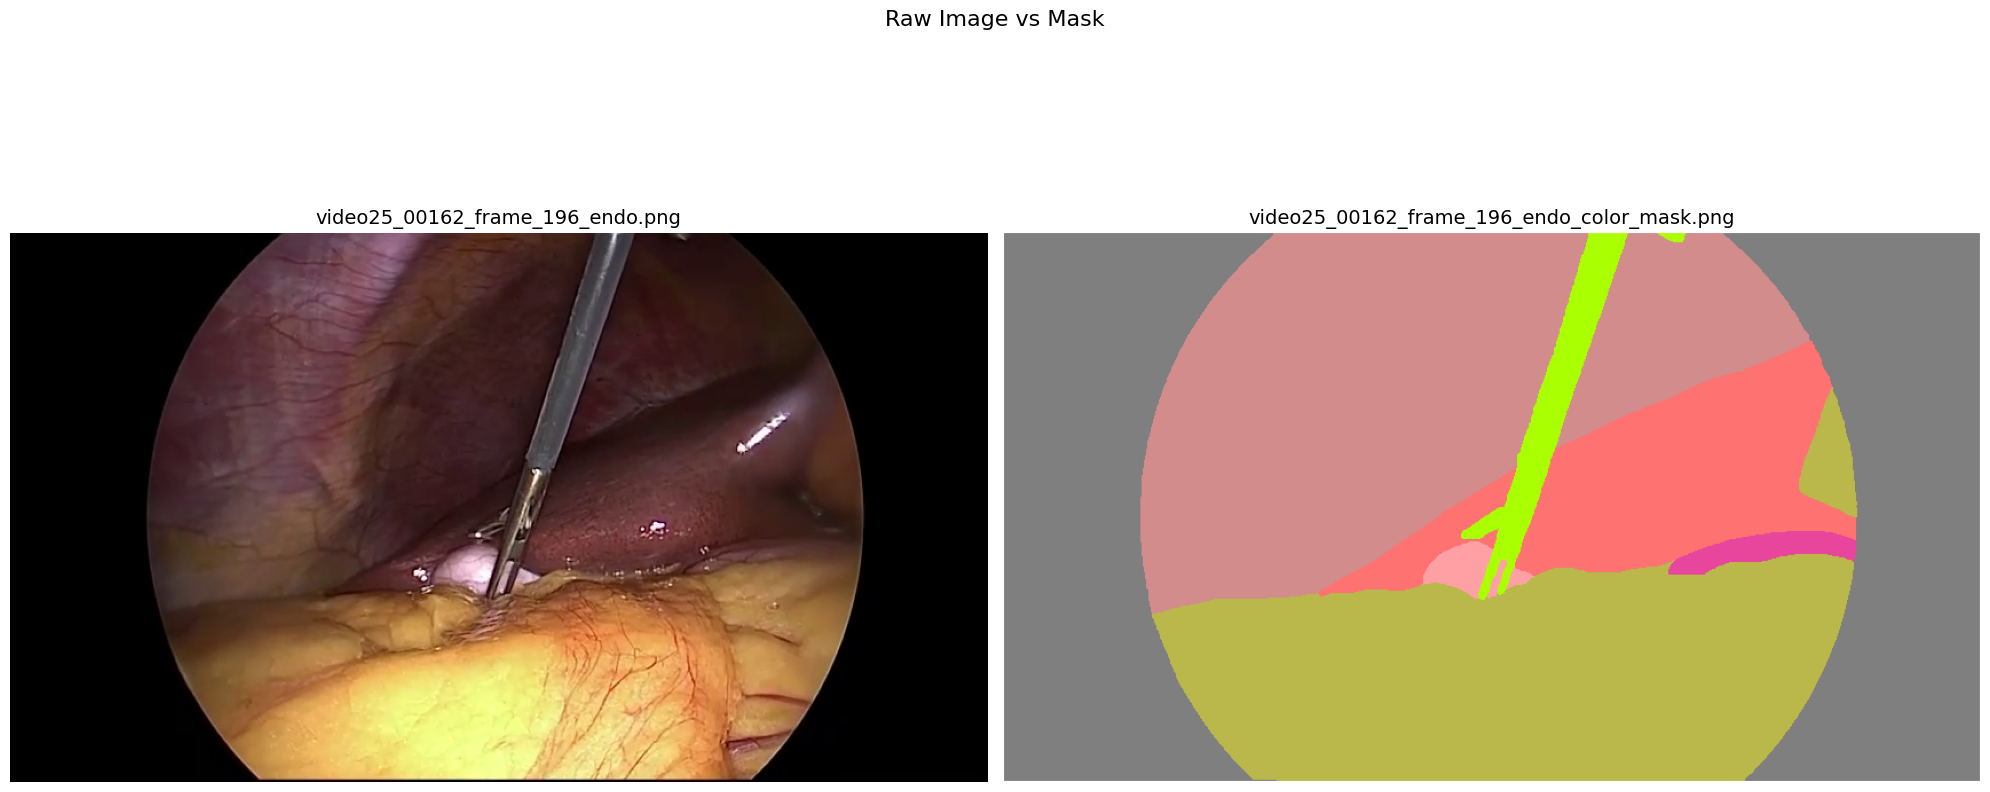

In [16]:
# Example usage:
plot_image_and_mask(rawimages_path, maskimages_path)


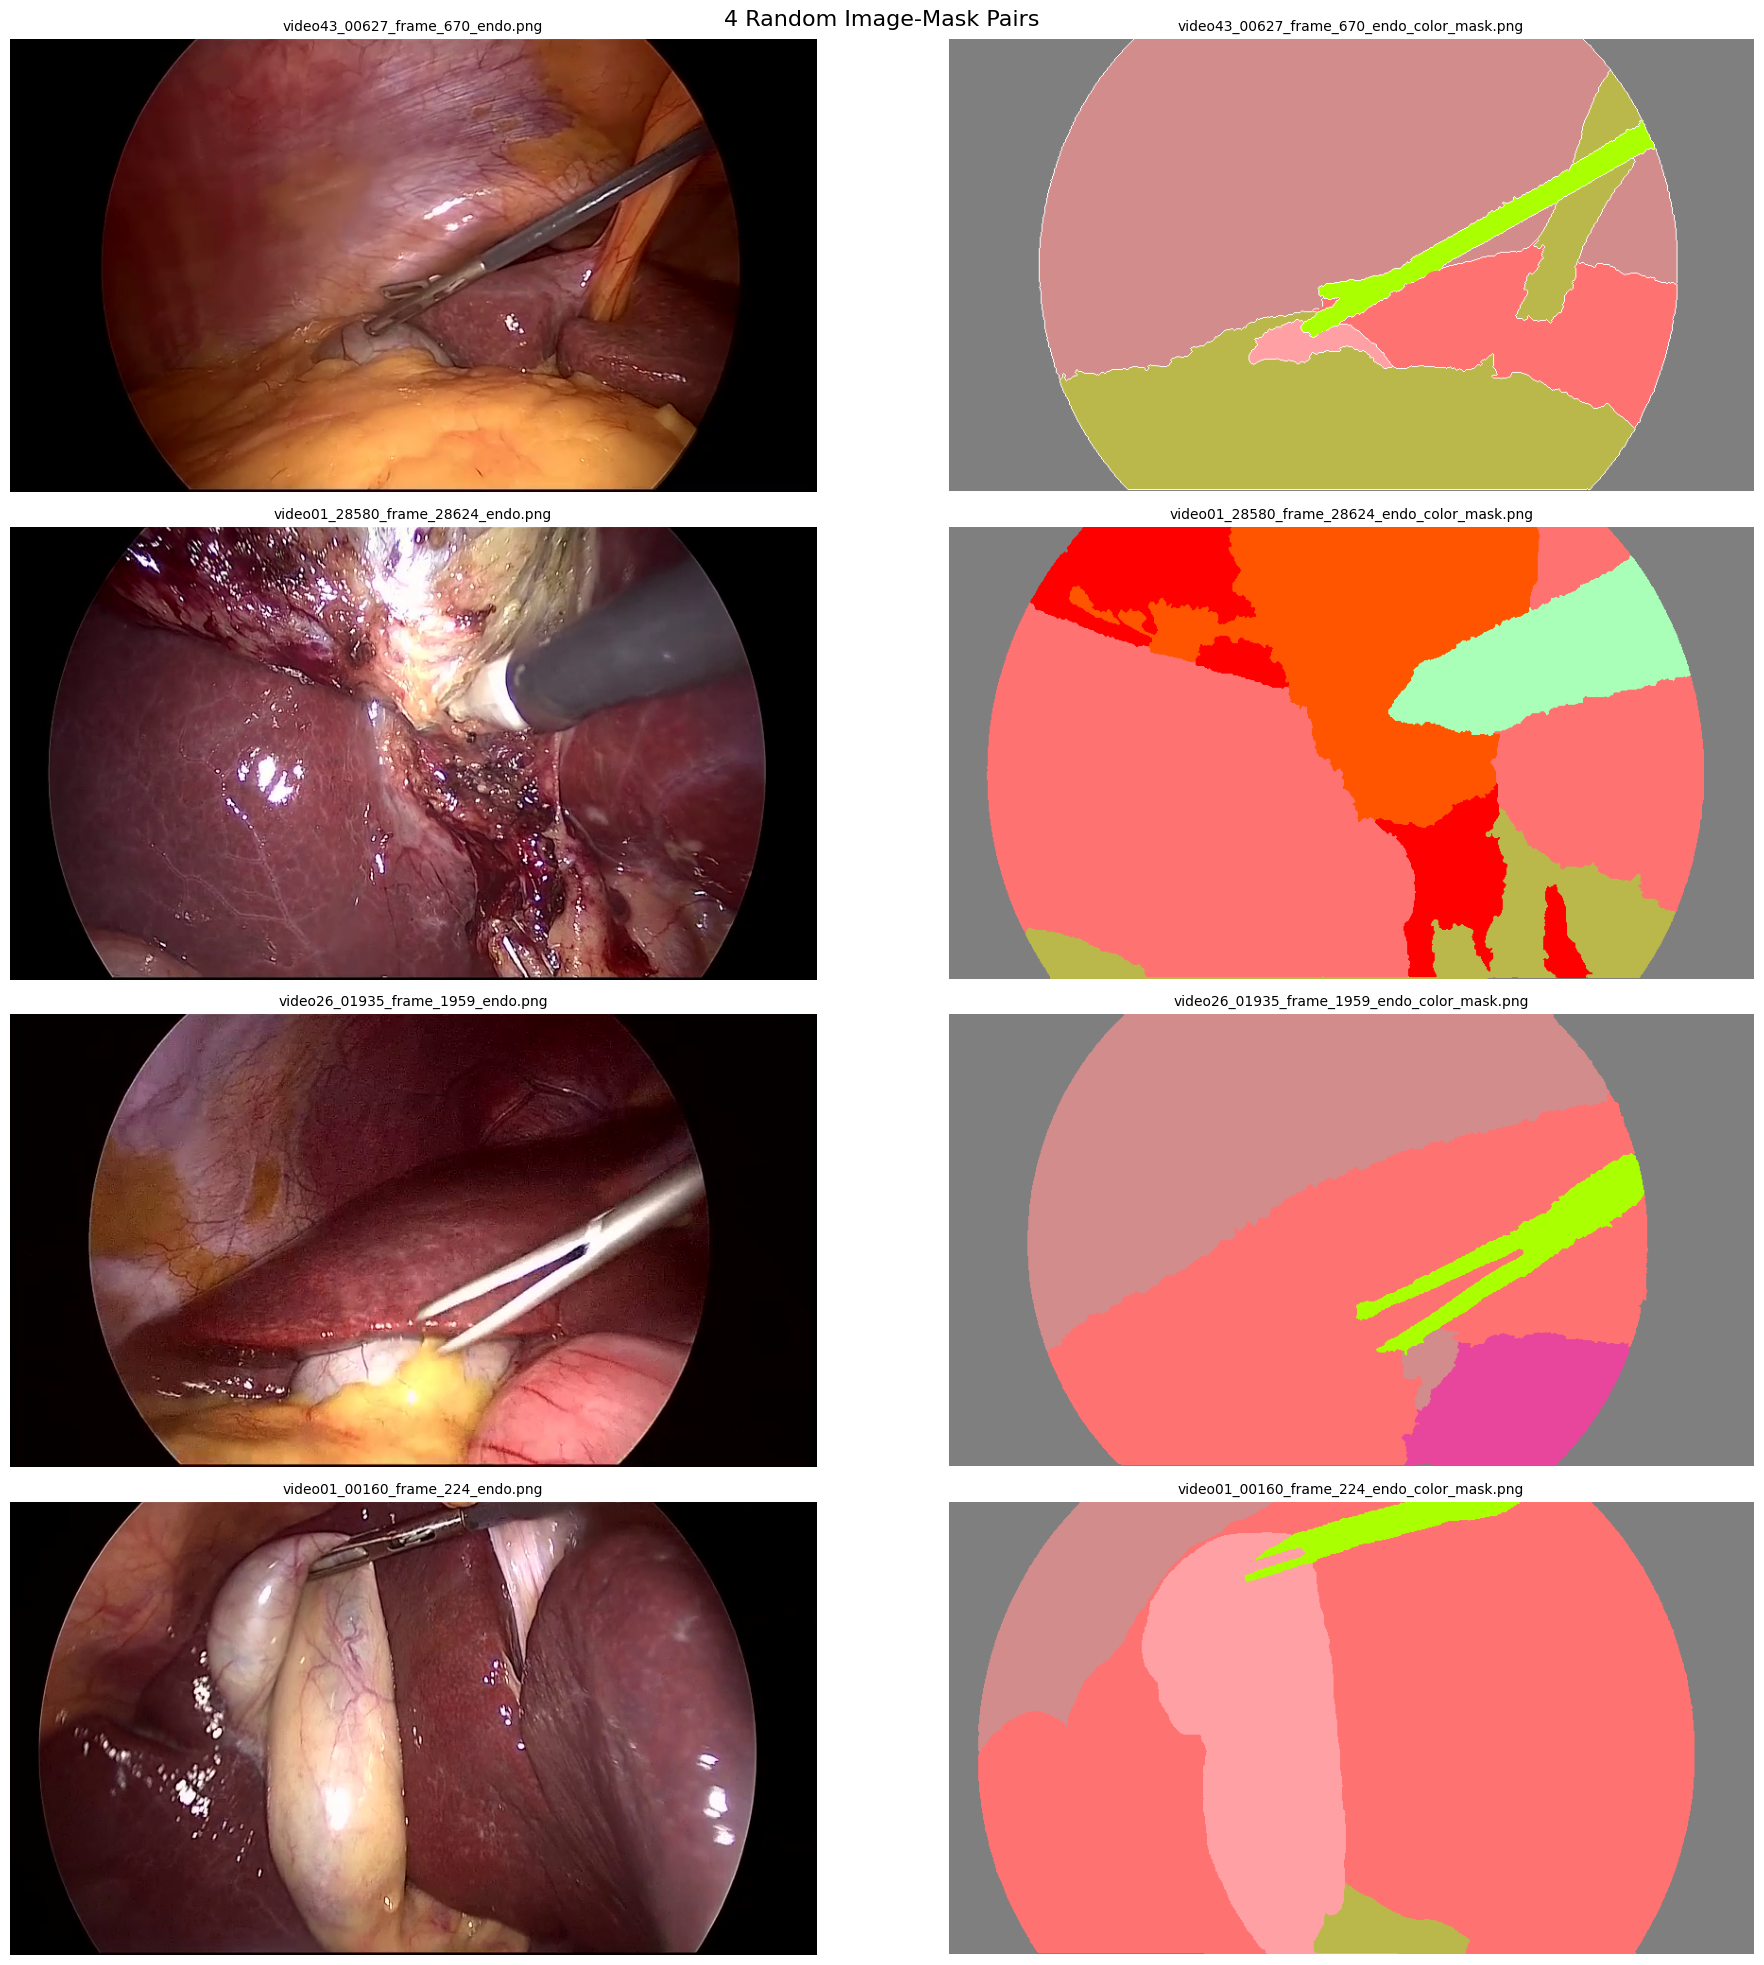

In [17]:
plot_multiple_pairs(rawimages_path, maskimages_path, num_pairs=4)

## Masks visualisation with contours

We will find unique colors in mask and draw segmentation contours for any color present in it. Since we don't have pure black color (RGB-0,0,0) for any of the classes in masks, we will use it to draw contours.

In [20]:
def draw_contour_for_one_color_on_mask(
    rawimages_path: str,
    rawimages_list: List[str],
    maskimages_path: str,
    maskimages_list: List[str]
) -> None:
    segmentation_classes = SegmentationClasses()
    
    # Choose a random image
    k = random.randint(0, len(rawimages_list) - 1)
    
    # Load images
    img_path = os.path.join(rawimages_path, rawimages_list[k])
    mask_path = os.path.join(maskimages_path, maskimages_list[k])
    
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    
    if img is None or mask is None:
        raise ValueError("Failed to load image or mask")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    # Get unique colors in mask
    unique_colors = np.unique(mask.reshape(-1, 3), axis=0)
    defined_colors = [color for color in unique_colors if tuple(color) in segmentation_classes.color_to_class]
    
    if not defined_colors:
        raise ValueError("No defined colors found in the mask")
    
    # Select a random color
    color = random.choice(defined_colors)
    
    # Get class information
    class_index = segmentation_classes.get_class_from_color(tuple(color))
    class_name = segmentation_classes.get_name_from_class(class_index)
    
    # Create mask for the selected color and find contours
    color_mask = cv2.inRange(mask, color, color)
    contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on a copy of the mask
    mask_with_contour = mask.copy()
    cv2.drawContours(mask_with_contour, contours, -1, (0, 0, 0), 4)
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    images = [img, mask, mask_with_contour]
    titles = [
        os.path.basename(img_path),
        'Mask',
        f'Mask with contour on {class_name}'
    ]
    
    for ax, image, title in zip(axes, images, titles):
        ax.imshow(image)
        ax.set_title(title, fontsize=20)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

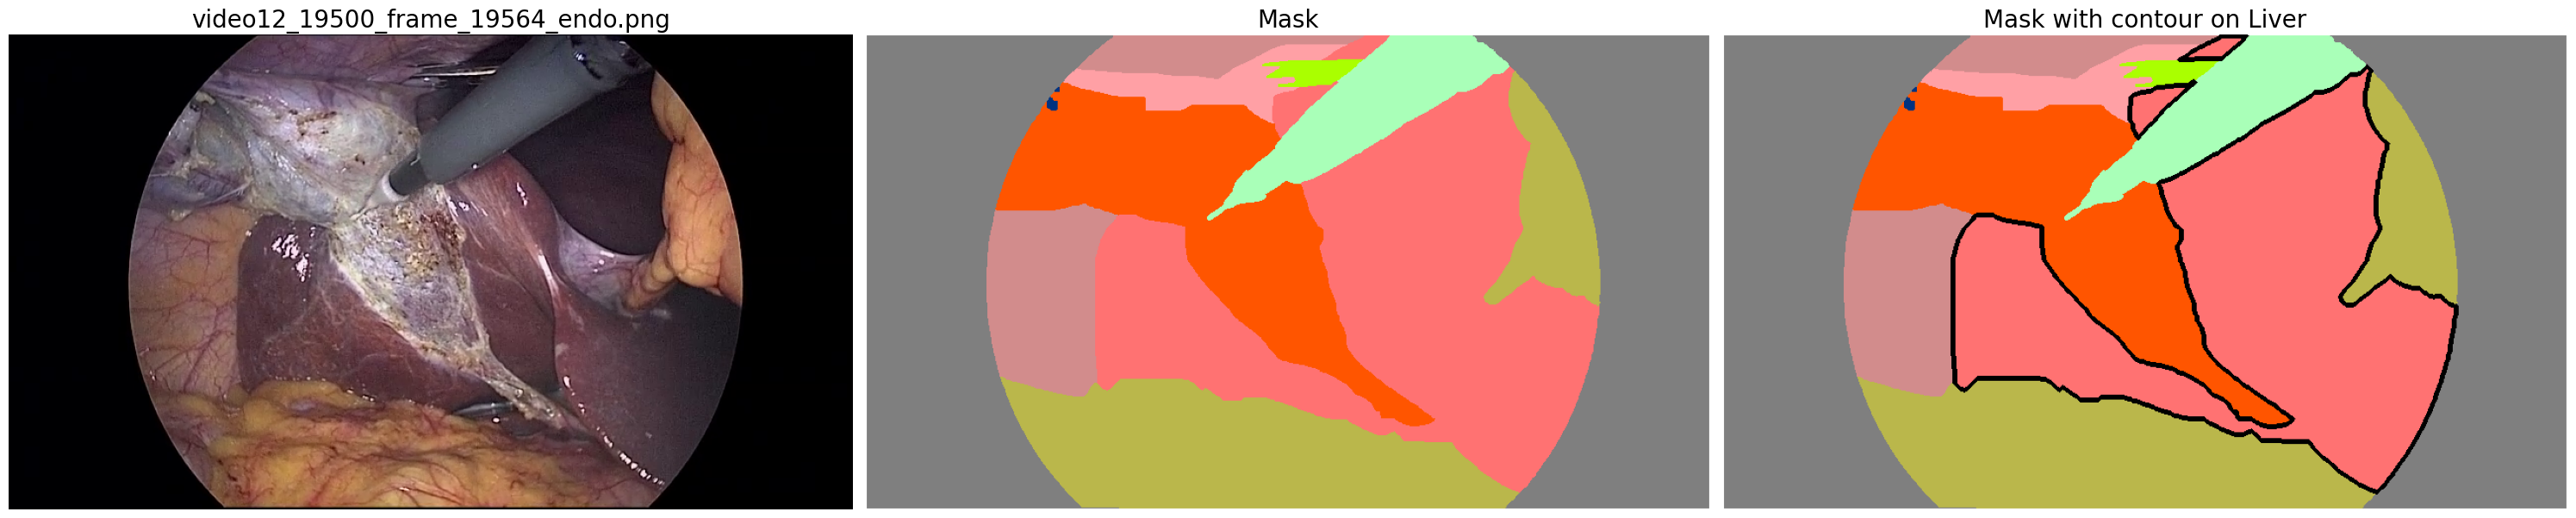

In [26]:
draw_contour_for_one_color_on_mask(rawimages_path, rawimages_list, maskimages_path, maskimages_list)